# Recommendation System for movies

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle

Reading files from the dataset

In [3]:
movies=pd.read_csv(r"/home/shreyas/Desktop/Recommend/movie.csv")
tags=pd.read_csv(r"/home/shreyas/Desktop/Recommend/tag.csv")
ratings=pd.read_csv(r"/home/shreyas/Desktop/Recommend/rating.csv")

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [6]:
tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


In [10]:
#remove '|' between genres
movies['genres']=movies['genres'].str.replace("|"," ")

In [12]:
#number of unique movies available in movies dataset
len(movies.movieId.unique())

27278

In [13]:
#number of unique movies rated by viewers
len(ratings.movieId.unique())

26744

In [15]:
#limit data to the users who have at least rated 55 movies
#its better to pivot now for collaborative filtering

ratings_f=ratings.groupby('userId').filter(lambda x: len(x)>=55)

#movie titles that survived after fitering

movie_list_ratings= ratings_f.movieId.unique().tolist()

In [20]:
#proportion movies that survived after filtering

prop_movies= len(ratings_f.movieId.unique())*100/len(movies.movieId.unique())
print("Proportion :",prop_movies)

('Proportion :', 97)


In [21]:
#proportion of users survived ater filtering

prop_users= len(ratings_f.userId.unique())*100/len(ratings.userId.unique())
print("Proportion :",prop_users)

('Proportion :', 57)


In [23]:
#filter movies in movies data set
movies=movies[movies.movieId.isin(movie_list_ratings)]

In [24]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [25]:
#map movies to moviID in dataset

mapping_file=dict(zip(movies.title.tolist(),movies.movieId.tolist()))

In [ ]:
#Remove timestamp from tags and ratings_f
tags.drop(['timestamp'],1,inplace=True)
ratings_f.drop(['timestamp'],1,inplace=True)

In [30]:
tags.head()

,userId,movieId,tag
0,18,4141,Mark Waters
1,65,208,dark hero
2,65,353,dark hero
3,65,521,noir thriller
4,65,592,dark hero


Here, we are going to use content based filtering.
The filtering will be done by using genres and tags.
So, we are going to merge movies and tags data set to get both genres and tags in one table.

In [31]:
#mixed = movies + tags

mixed=pd.merge(movies,tags,on='movieId',how='left')
mixed.head()

,movieId,title,genres,userId,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1644.0,Watched
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,computer animation
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,Disney animated feature
3,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,Pixar animation
4,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,TÃ©a Leoni does not star in this movie


In [34]:
mixed.fillna(" ",inplace=True)
mixed=pd.DataFrame(mixed.groupby('movieId')['tag'].apply(lambda x:"%s" % ' '.join(x)))
final=pd.merge(movies,mixed,on='movieId',how="left")
final['metadata']=final[['tag','genres']].apply(lambda x:' '.join(x),axis=1)
final[['movieId','title','metadata']].head(3)

,movieId,title,metadata
0,1,Toy Story (1995),Watched computer animation Disney animated fea...
1,2,Jumanji (1995),time travel adapted from:book board game child...
2,3,Grumpier Old Men (1995),old people that is actually funny sequel fever...


In [35]:
final.shape

(26694, 5)

## Creating latent matrix

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(stop_words='english')
tfidf_matrix=tfidf.fit_transform(final['metadata'])
tfidf_df=pd.DataFrame(tfidf_matrix.toarray(),index=final.index.tolist())
print(tfidf_df.shape)

(26694, 23704)


In [41]:
tfidf_df.head(3)
#its like sparce matrices i.e. having more zeros than ones or actual values

,0,1,2,3,4,5,6,7,8,9,...,23694,23695,23696,23697,23698,23699,23700,23701,23702,23703
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Dimesionality reduction

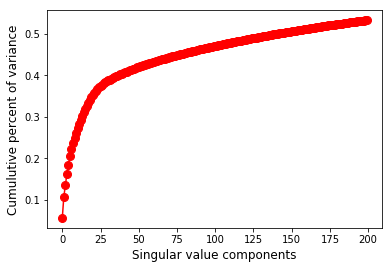

In [42]:
from sklearn.decomposition import TruncatedSVD

svd=TruncatedSVD(n_components=200)
latent_matrix=svd.fit_transform(tfidf_df)
explained=svd.explained_variance_ratio_.cumsum()
plt.plot(explained,'.-',ms=16,color='red')
plt.xlabel("Singular value components",fontsize=12)
plt.ylabel("Cumulutive percent of variance",fontsize=12)
plt.show()

#### The variance is 0.5 upto components 200.

In [44]:
n=200
latent_matrix_1_df=pd.DataFrame(latent_matrix[:,0:n],index=final.title.tolist())

In [46]:
latent_matrix_1_df.shape

(26694, 200)

In [52]:
latent_matrix_1_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story (1995),0.026804,0.052404,0.019479,0.003361,0.004004,-0.024907,0.115090,0.012749,-0.001627,0.103939,...,0.151137,0.104609,-0.011103,0.002556,0.000096,-0.078738,-0.083142,0.004837,-0.002401,0.023597
Jumanji (1995),0.010512,0.010537,0.025846,0.000882,0.013254,-0.001140,0.068154,0.012675,0.006184,0.050531,...,0.000879,-0.024603,0.041944,-0.055963,0.035622,-0.031525,0.020058,0.067103,-0.000649,0.014074
Grumpier Old Men (1995),0.038827,0.073948,-0.004930,-0.001323,0.031760,0.002476,-0.003612,-0.001630,-0.000253,0.000645,...,-0.025940,0.011721,-0.004735,0.004285,0.002393,0.011135,-0.002396,-0.012310,0.001923,0.013140
Waiting to Exhale (1995),0.136327,0.077169,-0.020606,-0.002103,0.101073,0.012071,-0.012106,-0.002062,-0.004896,-0.002583,...,-0.045180,-0.025120,0.001802,-0.037878,0.058699,-0.061952,-0.016508,0.063804,-0.058230,-0.075220
Father of the Bride Part II (1995),0.038644,0.084084,0.000456,0.000029,-0.013619,0.000075,0.013469,-0.000218,0.008462,0.013971,...,-0.004095,0.011323,-0.015962,-0.036492,0.041916,0.005134,0.008094,0.005957,0.028160,-0.027907


In [54]:
from sklearn.metrics.pairwise import cosine_similarity
#take latent vector for selected movie
a_1=np.array(latent_matrix_1_df.loc['Toy Story (1995)']).reshape(1,-1)


score=cosine_similarity(latent_matrix_1_df,a_1).reshape(-1)

dictdf={'content':score}

similar=pd.DataFrame(dictdf,index=latent_matrix_1_df.index)

similar.sort_values('content',ascending=False,inplace=True)

similar[1:].head(11)

,content
Toy Story 2 (1999),0.961456
"Bug's Life, A (1998)",0.907573
Ratatouille (2007),0.901458
"Monsters, Inc. (2001)",0.883230
Ice Age (2002),0.878304
Finding Nemo (2003),0.875968
Toy Story 3 (2010),0.863458
"Incredibles, The (2004)",0.790442
Monsters University (2013),0.771720
Up (2009),0.749724
